In [3]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import deque
from IPython.display import clear_output, display
import torch.multiprocessing as mp

In [4]:
#env = gym.make("Pong-v0")
env = gym.make("CartPole-v1")
env.reset()
#env.unwrapped.get_action_meanings()

array([ 0.01239285, -0.00379271, -0.00721933, -0.00299865])

In [5]:
'''#Test environment with random actions
env.reset()
#actions = [0,2,3]
for i in range(2000):
    env.render()
    a = env.action_space.sample()
    #a = np.random.choice(actions)
    state, reward, done, info = env.step(a)
    if done:
        env.reset()
env.close()'''

'#Test environment with random actions\nenv.reset()\n#actions = [0,2,3]\nfor i in range(2000):\n    env.render()\n    a = env.action_space.sample()\n    #a = np.random.choice(actions)\n    state, reward, done, info = env.step(a)\n    if done:\n        env.reset()\nenv.close()'

In [6]:
#env.reset()
'''state,reward,done,lives=env.step(2)
plt.imshow(downscale_obs(state, new_size=(42,42)))
print(reward,done)'''

'state,reward,done,lives=env.step(2)\nplt.imshow(downscale_obs(state, new_size=(42,42)))\nprint(reward,done)'

In [7]:
#t1=prepare_initial_state(env.render('rgb_array'),3)
#t2=prepare_multi_state(t,env.render('rgb_array')).shape
#t1.shape,t2.shape

In [24]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4,25)
        self.l2 = nn.Linear(25,50)
        self.actor_lin1 = nn.Linear(50,2)
        self.l3 = nn.Linear(50,25)
        self.critic_lin1 = nn.Linear(25,1)

    def forward(self,x):
        x = F.normalize(x,dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y),dim=0)
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c))
        return actor, critic

In [16]:
'''x =np.arange(start=10,stop=0,step=-1)
print(x)
gamma = 0.9
x[0]=-20
G = []
g = x[0]
G.append(g)
print(g)
for i in range(len(x)-1):
    g = g + gamma * x[i+1]
    G.append(g)
G'''

'x =np.arange(start=10,stop=0,step=-1)\nprint(x)\ngamma = 0.9\nx[0]=-20\nG = []\ng = x[0]\nG.append(g)\nprint(g)\nfor i in range(len(x)-1):\n    g = g + gamma * x[i+1]\n    G.append(g)\nG'

In [17]:
'''TestModel = ActorCritic()
state=env.step(1)[0]
a,_ = TestModel(prepare_initial_state(state))'''

'TestModel = ActorCritic()\nstate=env.step(1)[0]\na,_ = TestModel(prepare_initial_state(state))'

In [27]:
import time

In [72]:
def update_params(worker_opt,values,logprobs,rewards,clc=0.1,gamma=0.95):
        rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)
        logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1) #to Tensor and reverse
        values = torch.stack(values).flip(dims=(0,)).view(-1) #to Tensor and reverse
        Returns = []
        ret_ = torch.Tensor([0])#rewards_[0]
        #Ret.append(ret_)
        for r in range(rewards.shape[0]):
            ret_ = rewards[r] + gamma * ret_
            Returns.append(ret_)
        Returns = torch.stack(Returns).view(-1)
        Returns = F.normalize(Returns,dim=0)
        actor_loss = -1*logprobs * (Returns - values.detach())
        critic_loss = torch.pow(values - Returns,2)
        loss = actor_loss.sum() + clc*critic_loss.sum()
        loss.backward()
        worker_opt.step()
        return actor_loss, critic_loss, len(rewards)
        
def run_episode(worker_env, worker_model):
    state = torch.from_numpy(worker_env.env.state).float()
    values, logprobs, rewards = [],[],[]
    done = False
    j=0
    while (done == False):
        j+=1
        #run actor critic model
        policy, value = worker_model(state)
        values.append(value)
        #sample action
        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        logprob_ = policy.view(-1)[action]
        logprobs.append(logprob_)
        state_, _, done, info = worker_env.step(action.detach().numpy())
        state = torch.from_numpy(state_).float()
        if done:
            reward = -10
            worker_env.reset()
        else:
            reward = 1.0
        rewards.append(reward)
    return values, logprobs, rewards

def worker(t, worker_model, counter, params, losses): #q is mp Queue
    print("In process {}".format(t,))
    start_time = time.time()
    #play n steps of the game, store rewards
    worker_env = gym.make("CartPole-v1")
    worker_env.reset()
    worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters())
    worker_opt.zero_grad()
    for i in range(params['epochs']):
        worker_opt.zero_grad()
        #stores
        values, logprobs, rewards = run_episode(worker_env,worker_model)
        actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards)
        counter.value = counter.value + 1
        losses.put(eplen)
        if i % 50 == 0:
            print("Process: {} Maxrun: {} ALoss: {} CLoss: {}".format(t,eplen, \
                      actor_loss.detach().mean().numpy(),critic_loss.detach().mean().numpy()))
        if time.time() - start_time > 45:
            print("Done 45 seconds")
            break;

In [73]:
'''v=torch.arange(start=5,end=0,step=-1)
print(v[:-1],v[1:])'''

'v=torch.arange(start=5,end=0,step=-1)\nprint(v[:-1],v[1:])'

In [74]:
'''%%time
TestModel = ActorCritic()
worker_opt = optim.Adam(lr=1e-4,params=TestModel.parameters())
q2 = mp.Value('i',0)
params = {
    'epochs':5,
    'n_steps':5,
    'n_workers':1,
}
AC_step(0,TestModel,q2,params)'''

"%%time\nTestModel = ActorCritic()\nworker_opt = optim.Adam(lr=1e-4,params=TestModel.parameters())\nq2 = mp.Value('i',0)\nparams = {\n    'epochs':5,\n    'n_steps':5,\n    'n_workers':1,\n}\nAC_step(0,TestModel,q2,params)"

# <span style="color:red;">Train</span>

In [75]:
%%time
if __name__ == '__main__':
    MasterNode = ActorCritic()
    MasterNode.share_memory()
    processes = []
    params = {
        'epochs':1000,
        'n_workers':7,
    }
    counter = mp.Value('i',0)
    losses = mp.Queue()
    for i in range(params['n_workers']):
        p = mp.Process(target=worker, args=(i,MasterNode,counter,params,losses))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
    for p in processes:
        p.terminate()

    print(counter.value,processes[1].exitcode)

In process 0
In process 1
In process 2
In process 3
In process 4
In process 5
In process 6
Process: 3 Maxrun: 28 ALoss: 0.060241956263780594 CLoss: 0.03418976068496704
Process: 6 Maxrun: 26 ALoss: 0.05034090578556061 CLoss: 0.034537963569164276
Process: 0 Maxrun: 43 ALoss: 0.05275442823767662 CLoss: 0.01969188079237938
Process: 5 Maxrun: 39 ALoss: 0.051650065928697586 CLoss: 0.02143673412501812
Process: 1 Maxrun: 58 ALoss: 0.049718618392944336 CLoss: 0.015436741523444653
Process: 4 Maxrun: 42 ALoss: 0.05072680115699768 CLoss: 0.019803021103143692
Process: 2 Maxrun: 50 ALoss: 0.05277305468916893 CLoss: 0.01792260631918907
Process: 0 Maxrun: 24 ALoss: 0.02283882163465023 CLoss: 0.03526848554611206
Process: 2 Maxrun: 22 ALoss: 0.0008543675648979843 CLoss: 0.03945693373680115
Process: 6 Maxrun: 32 ALoss: 0.036029357463121414 CLoss: 0.023679405450820923
Process: 5 Maxrun: 15 ALoss: -0.10158392041921616 CLoss: 0.07822556048631668
Process: 3 Maxrun: 30 ALoss: 0.021618677303195 CLoss: 0.027394

In [76]:
losses_ = []
while not losses.empty():
    losses_.append(losses.get())

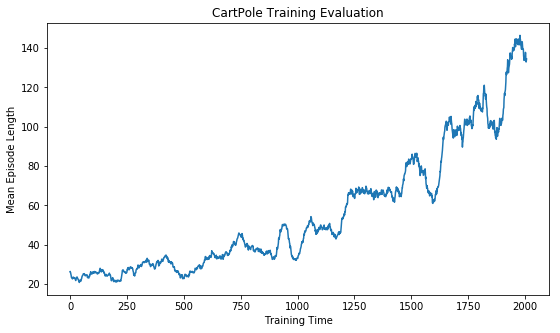

In [85]:
plt.figure(figsize=(9,5))
x = np.array(losses_)
N = 50
x = np.convolve(x, np.ones((N,))/N, mode='valid')
plt.ylabel("Mean Episode Length")
plt.xlabel("Training Time")
plt.title("CartPole Training Evaluation")
plt.plot(x)
#plt.savefig("avg_rewards.png")

## Test

In [68]:
steps = 2000
env = gym.make("CartPole-v1")
env.reset()
maxrun = 0
state = torch.from_numpy(env.env.state).float()
done = False
avg_run = 0
runs = int(25)
for i in range(runs):
    maxrun = 0
    done = False
    env.reset()
    state = torch.from_numpy(env.env.state).float()
    while(done==False):
        #env.render('human')
        policy, value = MasterNode(state)
        #sample action
        action = torch.distributions.Categorical(logits=policy.view(-1)).sample().detach().numpy()
        state_, reward, done, lives = env.step(action)
        
        env.render()
        #print(value,reward)
        state = torch.from_numpy(state_).float()
        maxrun += 1
    avg_run += maxrun
avg_run = avg_run / runs
env.close()
print("Maxrun: {}".format(avg_run,))

Maxrun: 145.08


In [14]:
'''TestModel = ActorCritic()
env = gym.make("CartPole-v1")
env.reset()
maxrun = 0
state = torch.from_numpy(env.env.state).float()
done = False
avg_run = 0
runs = int(200)
for i in range(runs):
    maxrun = 0
    done = False
    env.reset()
    state = torch.from_numpy(env.env.state).float()
    while(done==False):
        #env.render('human')
        policy, value = TestModel(state)
        #sample action
        action = torch.distributions.Categorical(logits=policy.view(-1)).sample()
        state_, reward, done, lives = env.step(env.action_space.sample())
        state = torch.from_numpy(state_).float()
        maxrun += 1
    avg_run += maxrun
avg_run /= runs
env.close()
print("Maxrun: {}".format(avg_run,))'''

'TestModel = ActorCritic()\nenv = gym.make("CartPole-v1")\nenv.reset()\nmaxrun = 0\nstate = torch.from_numpy(env.env.state).float()\ndone = False\navg_run = 0\nruns = int(200)\nfor i in range(runs):\n    maxrun = 0\n    done = False\n    env.reset()\n    state = torch.from_numpy(env.env.state).float()\n    while(done==False):\n        #env.render(\'human\')\n        policy, value = TestModel(state)\n        #sample action\n        action = torch.distributions.Categorical(logits=policy.view(-1)).sample()\n        state_, reward, done, lives = env.step(env.action_space.sample())\n        state = torch.from_numpy(state_).float()\n        maxrun += 1\n    avg_run += maxrun\navg_run /= runs\nenv.close()\nprint("Maxrun: {}".format(avg_run,))'